In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, suppress=True, linewidth=150)

In [7]:
#System definition

L = 10 #m    (length of the footbridge)
b = 2  #m    (width of the footbridge)

h_layer= 0.0005 #m 



In [8]:
#Material definition

E1 = 38.6 #GPa
E2 = 8.27 #GPa
G12 = 4.14 #GPa
nu12 = 0.26
nu21=nu21 = (E2/E1)*nu12

#E1 = float(input("Donner le module de Young dans la direction de la longueur (E1) en GPa: " ) or 181)
#E2 = float(input("Donner le module de Young dans la direction de la largeur (E2) en GPa: " ) or 10.3)
#nu12 = float(input("Donner le coefficient de poisson nu12 : " ) or 0.28)
#nu21 = (E2/E1)*nu12
#G12=float(input("Donner le module de cisaillement G12 en GPa) : " ) or 7.17)


In [9]:
#Code to define the orientations of the fibers in the different laminates and put it into a list
def orientation(liste):
    code_orientation = liste.split(",")
    for i in range(0,len(code_orientation)):
        code_orientation[i] = int(code_orientation[i])
        i +=1
    return code_orientation

In [10]:
# This function gives the deformation for each ply, given the mechanical parameters
def get_deformation(liste,E1,E2,nu21,nu12,G12,h,Nx,Ny,Nxy,Mx,My,Mxy):
    Q11 = E1/(1-nu21*nu12)*10**9
    Q12 = nu12*E2/(1-nu21*nu12)*10**9
    Q22 = E2/(1-nu21*nu12)*10**9
    Q66 = G12*10**9
    
    liste_different_orientation = []
   
    #To get the different angles of orientation of the fibers
    for i in range(0,len(liste)):
        if liste[i] in liste_different_orientation:
            continue
        else:
            liste_different_orientation.append(liste[i])
    
    liste_different_orientation = np.array(liste_different_orientation)
    
    Qtot = np.zeros((len(liste_different_orientation), 3, 3))
    
    # To get the different matrices Q at each ply
    for i in range(0,len(liste_different_orientation)):
        a = liste_different_orientation[i]*(np.pi/180)
        m = np.cos(a)
        n = np.sin(a)
        Qxx = Q11*m**4+Q22*n**4+2*(Q12+2*Q66)*m**2*n**2
        Qxy = (Q11+Q22-4*Q66)*m**2*n**2+Q12*(m**4+n**4)
        Qyy = Q11*n**4+Q22*m**4+2*(Q12+2*Q66)*m**2*n**2
        Qxs = (Q11-Q12-2*Q66)*m**3*n-(Q22-Q12-2*Q66)*n**3*m
        Qys = (Q11-Q12-2*Q66)*m*n**3-(Q22-Q12-2*Q66)*m**3*n
        Qss = (Q11+Q22-2*Q12-2*Q66)*m**2*n**2+Q66*(n**4+m**4)
        Qtot[i] = np.array([[Qxx,Qxy,Qxs],[Qxy,Qyy,Qys],[Qxs,Qys,Qss]])
        
    #To get the position of the different plies, with the origin at the centre of the plate (zd for down, zu for up), z axis oriented from up to down
     
    ply_pos = np.zeros((len(liste), 3))
    t = h/len(liste)
    
    for i in range(0,len(liste)):
        zu = -h/2+i*t
        zd = -h/2+(i+1)*t
        zm = (zu+zd)/2
        ply_pos[i] = np.array([[zu,zm,zd]])
        
    # Global coordinates
    coord  = ply_pos.reshape(3*len(ply_pos))
        
    #Definition of the matrices A,B,D
    A = np.zeros((3, 3))
    B = np.zeros((3, 3))
    D = np.zeros((3, 3))
    
    for i in range(0,len(liste)):
        Qx = np.zeros((3,3))
        ply_pos_i = np.array(ply_pos[i])
        for j in range(0,len(liste_different_orientation)):
            if liste[i] == liste_different_orientation[j]:
                Qx = Qtot[j]
            else:
                continue
        A += Qx*(ply_pos[i,2]-ply_pos[i,0])
        B += (1/2)*Qx*(ply_pos[i,2]**2-ply_pos[i,0]**2)
        D += (1/3)*Qx*(ply_pos[i,2]**3-ply_pos[i,0]**3)
        
        
    #Obtention of global strains and curvature (the x axis is in the direction of the length, the y axis perpendicular to it)
    force_array = np.array([Nx,Ny,Nxy,Mx,My,Mxy])
    sys = np.concatenate((np.concatenate((A, B), axis=1), np.concatenate((B,D),axis = 1)),axis = 0)
    sys_inv = np.linalg.inv(sys)
    global_deformation = sys_inv@force_array
    
    #Obtention of the deformations and stresses at each slice of the composite in global coordinates
    
    eps_up = np.zeros((len(liste), 3))
    eps_mid = np.zeros((len(liste), 3))
    eps_down = np.zeros((len(liste), 3))
    eps_i = np.zeros((len(liste), 3,3))
    
    sig_up = np.zeros((len(liste), 3))
    sig_il_up= np.zeros((len(liste), 3))
    sig_mid = np.zeros((len(liste), 3))
    sig_il_mid=np.zeros((len(liste), 3))
    sig_down = np.zeros((len(liste), 3))
    sig_il_down=np.zeros((len(liste), 3))
    sig_i = np.zeros((len(liste), 3,3))
    sig_il= np.zeros((len(liste), 3,3))
    
    for i in range(0, len(liste)):

        #transformation matrix
        a=liste[i]*(np.pi/180)
        m = np.cos(a)
        n = np.sin(a)
        T=np.array([[m**2, n**2, 2*m*n],[n**2,m**2, -2*m*n],[-m*n, n*m,m**2-n**2 ]])
        

        Qx = np.zeros((3,3))
        
        eps_up[i] = global_deformation[:3]+ply_pos[i,0]*global_deformation[3:]
        eps_mid[i] = global_deformation[:3]+((ply_pos[i,0]+ply_pos[i,2])/2)*global_deformation[3:]
        eps_down[i] = global_deformation[:3]+ply_pos[i,2]*global_deformation[3:]
        eps_i[i] = np.concatenate((np.concatenate((eps_up[i],eps_mid[i]),axis=0),eps_down[i]),axis=0).reshape(3,3)
        
        for j in range(0,len(liste_different_orientation)):
            if liste[i] == liste_different_orientation[j]:
                Qx = Qtot[j]
            else:
                continue
            
        sig_up[i] = Qx@eps_up[i]
        print(f"sig_up{sig_up[i]}")
        sig_il_up[i]=T@sig_up[i]
        print(f"{T=}")
        print(f"sigil_up ={sig_il_up[i]}")
        sig_mid[i] = Qx@eps_mid[i]
        sig_il_mid[i]=T@sig_mid[i]
        sig_down[i] = Qx@eps_down[i]
        sig_il_down[i]=T@sig_down[i]
        sig_i[i] = np.concatenate((np.concatenate((sig_up[i],sig_mid[i]),axis=0),sig_down[i]),axis=0).reshape(3,3)
        sig_il[i]=np.concatenate((np.concatenate((sig_il_up[i],sig_il_mid[i]),axis=0),sig_il_down[i]),axis=0).reshape(3,3)

    print(Qx)
    print(f"sig_i={sig_i}")
    print(f"sig_il={sig_il}")
    
    
    return coord, eps_i, sig_i, sig_il


In [11]:
#print stresses and strains graph


def print_stresses_strains(eps_i, sig_i, liste, coord):

    #plot of the results
    
    giga_eps = eps_i.reshape(3*len(liste),3)
    giga_sig = sig_i.reshape(3*len(liste),3)

    #get the maximum values
    maxeps=[]
    maxsig=[]

    #max_eps_x=np.max()
    
    plt.figure(figsize=(7, 5))

    #plt.subplot(131)
    plt.plot(giga_eps[:,0],coord, '-o', mfc="w",label=r"$\varepsilon_{x}$")  #tip: le r devant fait du LateX !!
    plt.plot(giga_eps[:,1],coord,'-o', mfc="w",label=r"$\varepsilon_{y}$")
    plt.plot(giga_eps[:,2],coord,'-o', mfc="w",label=r"$\gamma_{xy}$")
    plt.xlabel('Strains [-]')
    plt.ylabel('z [m]')
    plt.title('Strains in each fibers (top/middle/bottom)')
    i = np.abs(giga_eps[:,0]).argmax()
    maxeps.append(giga_eps[:,0][i])
    plt.text(giga_eps[:,0][i]*0.5, coord[i]*0.9, rf"$\varepsilon_{{x}}={giga_eps[:,0][i]:.6e}$")  #tip: quand f et r mettre deux accolades autour du subscript pour pas que cela soit considérer comme une variable ! 
    i = np.abs(giga_eps[:,1]).argmax()
    maxeps.append(giga_eps[:,1][i])
    plt.text(giga_eps[:,1][i]*0.5, coord[i]*0.9, rf"$\varepsilon_{{y}}={giga_eps[:,1][i]:.6e}$")
    i = np.abs(giga_eps[:,2]).argmax()
    maxeps.append(giga_eps[:,2][i])
    plt.text(giga_eps[:,2][i]*0.5, coord[i]*0.9, rf"$\gamma_{{xy}}={giga_eps[:,2][i]:.6e}$")
    plt.legend()

    plt.show()
    print(f'{maxeps = }')

    #plt.subplot(132)
    plt.plot(giga_sig[:,0],coord,'-o', mfc="w",label=r"$\sigma_{{x}}$")
    plt.plot(giga_sig[:,1],coord,'-o', mfc="w",label=r"$\sigma_{{y}}$")
    plt.plot(giga_sig[:,2],coord,'-o', mfc="w", label=r"$\tau_{{xy}}$")
    plt.xlabel('Stresses [Pa]')
    plt.ylabel('z [m]')
    plt.title('Stresses in each fibers (top/middle/bottom)')
    i = np.abs(giga_sig[:,0]).argmax()
    maxsig.append(giga_sig[:,0][i])
    plt.text(giga_sig[:,0][i]*0.5, coord[i]*0.9, rf"$\sigma_{{x}}={giga_sig[:,0][i]:.6e}$")  #tip: quand f et r mettre deux accolades autour du subscript pour pas que cela soit considérer comme une variable ! 
    i = np.abs(giga_sig[:,1]).argmax()
    maxsig.append(giga_sig[:,1][i])
    plt.text(giga_sig[:,1][i]*0.5, coord[i]*0.9, rf"$\sigma_{{y}}={giga_sig[:,1][i]:.6e}$")
    i = np.abs(giga_sig[:,2]).argmax()
    maxsig.append(giga_sig[:,2][i])
    plt.text(giga_sig[:,2][i]*0.5, coord[i]*0.9, rf"$\tau_{{xy}}={giga_sig[:,2][i]:.6e}$")
    plt.legend()

    plt.show()
    print(f'{maxsig = }')

    return None

In [12]:
#caracteristic values for failure for glass fibers E with epoxy resin
Vf = 0.6
Xt = 1400*10**6 #Pa
Xc = 910*10**6 #Pa
Yt = 35*10**6 #Pa
Yc = 110*10**6 #Pa
S = 70*10**6 #Pa 
#(from table 12.1 p 249)


def failure(sig_il, xt,yt, xc, yc,s, liste):
    F11=1/(xc*xt)
    F22=1/(yc*yt)
    F1=1/xt-1/xc
    F2=1/yt-1/yc
    F12=-0.5*np.sqrt(F11*F22) #tsai Hhan for a theoretical determination of Fij
    F66=1/s**2

    for i in range(0, len(liste)):
        for j in range(3):
        #failure criteria: filure occurs when the equation is equal to 1
            f=F11*sig_il[i,j,0]**2+F22*sig_il[i,j,1]**2+F66*sig_il[i,j,2]**2+2*(F12*sig_il[i,j,0]*sig_il[i,j,1])+F1*sig_il[i,j,0]+F2*sig_il[i,j,1]
            if f<1:
                fail=False
            else:
                fail=True
                liste.append(liste)
                
                raise ValueError("Failure !!!!!")
            
    if fail==False:
        print('There is no failure !')

    return fail



In [19]:
#Test of the function get_deformation
#liste = input("Donner les orientations des fibres en degré sous la forme: a,b,c...") or "0, 30, -45"
liste = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,90,90,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
print(liste)
h = h_layer*len(liste)
print(len(liste))
print(h)

#Loads definition

My=0 #kNm
Mx=0 #kNm 
Mxy=0 #kNm
Nx=(185.44+1.35*21*h*2*2*L**2/8)/(0.1-h)*10**3-12*10**3 #N (adding the self weight)
Ny=94.5*10**3 #N
Nz=0 #N
Nxy=0 #N



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 90, 90, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
34
0.017


In [20]:
coord, eps_i, sig_i, sig_il=get_deformation(liste,E1,E2,nu21,nu12,G12,h,Nx,Ny,Nxy,Mx,My,Mxy)


sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
     

sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])
sigil_up =[ 1.629168e+08  6.629558e+06 -1.126575e-12]
sig_up[ 1.629168e+08  6.629558e+06 -1.126575e-12]
T=array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
     

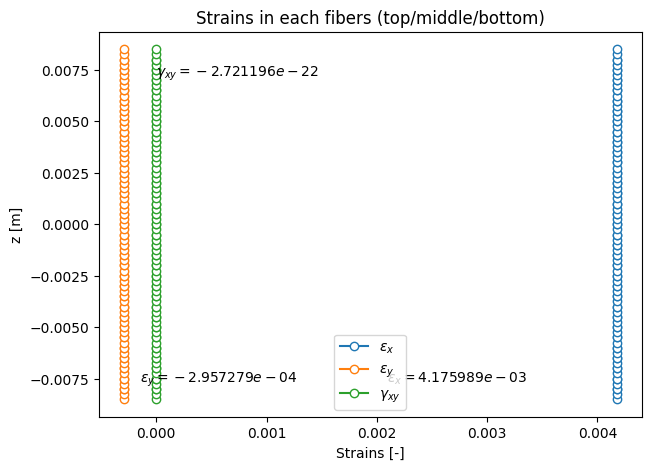

maxeps = [0.0041759886575589746, -0.0002957279372439538, -2.7211955256726385e-22]


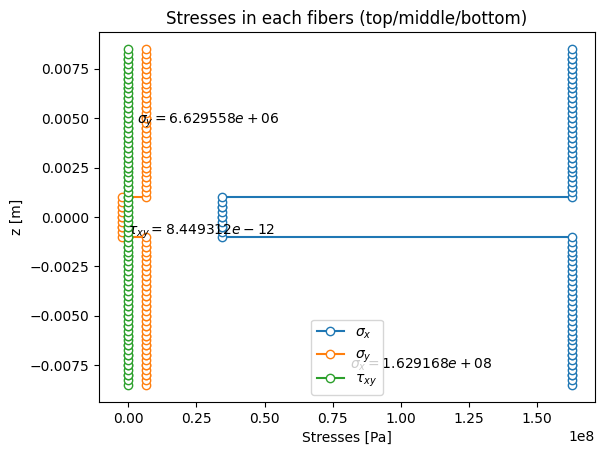

maxsig = [162916847.27954254, 6629558.068331165, 8.449312107213253e-12]
There is no failure !
False


In [21]:
coord, eps_i, sig_i, sig_il=get_deformation(liste,E1,E2,nu21,nu12,G12,h,Nx,Ny,Nxy,Mx,My,Mxy)
print_stresses_strains(eps_i, sig_i, liste, coord)
fail=failure(sig_il, Xt,Yt, Xc, Yc,S, liste)
print(fail)

In [27]:
#moment of inertia

b_sup=2000
b_inf=1260
H=100
angle=15
l=H/np.cos((90-15)*180/np.pi)

n0=15 #on one side only
n90=4

n0_3=2
n90_3=2

#areas

A1_sup1=b_sup*n0*h_layer
A2_sup=b_sup*n90*h_layer
A1_sup2=b_sup*n0*h_layer

A1_inf1=b_inf*n0*h_layer
A2_inf=b_inf*n90*h_layer
A1_inf2=b_inf*n0*h_layer

A1_cot1=l*n0_3*h_layer
A1_cot2=l*n0_3*h_layer
A2_cot=l*n90_3*h_layer

#lever arm

b1_sup1=H-h_layer*n0/2
b2_sup=H-h_layer*n90/2-h_layer*n0
b1_sup2=H-h_layer*(n90+n0+n0/2)

b1_inf1=h_layer*n0/2
b2_inf=h_layer*n90/2-h_layer*n0
b1_inf2=h_layer*(n90+n0+n0/2)

b_cot=H/2

#neutral axis

nz=(E1*(A1_sup1*b1_sup1+A1_inf1*b1_inf1+b_cot*(A1_cot1+A1_cot2)*2+A1_sup2*b1_sup2+A1_inf2*b1_inf2)+E2*(A2_inf*b2_inf+A2_sup*b2_sup+2*A2_cot*b_cot))/(E1*(A1_sup1+A1_sup2+A1_inf1+A1_inf2+2*(A1_cot1+A1_cot2))+E2*(A2_inf+A2_sup+2*(A2_cot+A2_cot)))
print(f"Center of gravity from the bottom outer layer = {nz} mm")

#second moment of inertia

I1_sup1=(n0*h_layer)**3*b_sup/12+A1_sup1*(b1_sup1-nz)**2
I2_sup=(n90*h_layer)**3*b_sup/12*E2/E1+A2_sup*(b2_sup-nz)**2
I1_sup2=(n0*h_layer)**3*b_sup/12*E2/E1+A1_sup2*(b1_sup2-nz)**2

I1_inf1=(n0*h_layer)**3*b_inf/12+A1_inf1*(b1_inf1-nz)**2
I2_inf=(n90*h_layer)**3*b_inf/12*E2/E1+A2_inf*(b2_inf-nz)**2
I1_inf2=(n0*h_layer)**3*b_inf/12*E2/E1+A1_inf2*(b1_inf2-nz)**2

I1_cot=(n0_3*h_layer)**3*l/12*2+2*A1_cot1*(b_cot-nz)**2
I2_cot=(n90_3*h_layer)**3*l/12+A2_cot*(b_cot-nz)**2

I=I1_sup1+I1_sup2+I1_inf1+I1_inf2+E2/E1*(I2_sup+I2_inf)+I1_cot*2+I2_cot*2*E2/E1

print(f"Second moment of inertia I = {I} mm^4")




Center of gravity from the bottom outer layer = 61.17463711823578 mm
Second moment of inertia I = 119288.73695730635 mm^4


In [29]:
q= 4.5 #kN/m
q=q+21*h*2*2*L**2/8

In [30]:
w=5*q*E1*10**6*I/(384*10000**4)
print(f"Longitudinal deflection: {w} mm")
print(f"Limit deflection L/300: {10000/300} mm")
print('  ')
I_sup=I1_sup1+I1_sup2+(I2_sup)*E2/E1
wy=5*E1*10**6*I_sup/(384*2000**4)
print(f"Transversal deflection: {wy} mm")
print(f"Limit deflection L/300: {2000/300} mm")

Longitudinal deflection: 0.00013399946127661168 mm
Limit deflection L/300: 33.333333333333336 mm
  
Transversal deflection: 0.001460496779390454 mm
Limit deflection L/300: 6.666666666666667 mm
